### Implementing Residual connection_ with large batch size-extra layer
##### 3 GCN layer

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import deepchem as dc
import os
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import BatchNorm1d

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GCNLayer(nn.Module):
    
    def __init__(self,in_feats,out_feats,batch_norm=True):
        
        super().__init__()
        self.graph_conv = GCNConv(in_channels=in_feats,out_channels=out_feats)
        self.dropout = nn.Dropout(p=0.6)
        self.batch_norm = batch_norm
        
        ## implementing residual
        self.res_connection = nn.Linear(in_feats,out_feats)
        
        ## implementing BatchNorm
        if self.batch_norm:
            self.bn = BatchNorm1d(out_feats)
        
    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.graph_conv.reset_parameters()
        self.res_connection.reset_parameters()
          
    def forward(self,x,edge_index):
        
        ### Extracting data from batch
        new_feats = self.graph_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats ### residual added
        #new_feats = self.dropout(new_feats)
        
        if self.batch_norm:
            return self.bn(new_feats)
        else:
            return new_feats

In [3]:
class GCNNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        ## GCN layers
        self.GCNConv1 = GCNLayer(30,64,batch_norm=False) ## Putting batch norm false
        self.GCNConv2 = GCNLayer(64,64,batch_norm=False) ## adding a layer of 64 to 64
#         self.GCNConv3 = GCNLayer(64,32,batch_norm=False)

        ### Predictor layers
        self.lin1 = nn.Linear(64,128)
        self.lin2 = nn.Linear(128,1)
        
        
    def forward(self,data):
        
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.relu(self.GCNConv1(x,edge_index))
        x = F.relu(self.GCNConv2(x,edge_index))
#         x = F.relu(self.GCNConv3(x,edge_index))
        
        x = global_mean_pool(x,batch)
        
        x = F.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        
        return x      

In [4]:
### Old with our refinement
##clean_data = pd.read_csv(r"Data.csv")

In [5]:
## same data use for p-gp interaction and Refined Docking
clean_data = pd.read_csv("FinalClearData-refined.csv")

In [6]:
data = clean_data

In [7]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [8]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "FinalClearData-refined.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [9]:
dataset = BBBDataset(root=".",)

Processing...
3011it [00:02, 1238.41it/s]
Done!


In [10]:
### Splitting of data
from torch.utils.data import random_split

train_set, test_set = random_split(dataset,[2000,1011]) ## 70:30

trainloader = DataLoader(train_set,shuffle=True,batch_size=256,drop_last=True) ## TrainLoader
testloader = DataLoader(test_set, shuffle=True,batch_size=256,drop_last=True)  ## TestLoader

In [11]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = GCNNetwork()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,) ## Weight decay might be reason for low validation loss than training
                                                ## 5ncrease learning rate 0.5

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

GCNNetwork(
  (GCNConv1): GCNLayer(
    (graph_conv): GCNConv(30, 64)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=30, out_features=64, bias=True)
  )
  (GCNConv2): GCNLayer(
    (graph_conv): GCNConv(64, 64)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=64, out_features=64, bias=True)
  )
  (lin1): Linear(in_features=64, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
)

### Metrics

In [12]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,matthews_corrcoef

In [13]:
## Base Metircs to convert probablity to binary
def base_metrics(y_prob,y_true):
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    
    return (np.array(y_true),y_prob)

In [14]:
## accuracy counter
def accuracy_counter(y_true,y_prob):
    return accuracy_score(y_true,y_prob)    

In [15]:
### F1_scorer
def f1_scorer(y_true,y_prob):
    return f1_score(y_true,y_prob)

In [16]:
### Precision
def precision_counter(y_true,y_prob):
    return precision_score(y_true,y_prob)

In [17]:
### Recall score
def recall_counter(y_true,y_prob):
    return recall_score(y_true,y_prob)
    

In [20]:
### ROC
def roc_auc_scorer(y_true,y_prob):
    return roc_auc_score(y_true,y_prob)

In [21]:
### MCC score
def MCC_scorer(y_true,y_prob):
    return matthews_corrcoef(y_true,y_prob)

### Train/Test

##### Implementing Early stopping

In [22]:
from TorchTools import EarlyStopping
## initialize the early_stopping object
early_stopping = EarlyStopping(patience=20, verbose=True,path="GCNcheckpoint.pt")

In [23]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    ## metrics
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    mcc_score = MCC_scorer(true,proab)
    
    return (av_loss,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score,mcc_score)
        

In [24]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    
    ## metrics
    #accuracy = accuracy_counter(proab,y_true)
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    mcc_score = MCC_scorer(true,proab)
    
    
    return (val,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score,mcc_score)

In [26]:
from lrcurve import PlotLearningCurve
import numpy as np
epochs = 200

############# RealTime Plotting ###################

# plot = PlotLearningCurve(
#     mappings = {
#         'loss': { 'line': 'train', 'facet': 'loss' },
#         'val_loss': { 'line': 'validation', 'facet': 'loss' },
#         'acc': { 'line': 'train', 'facet': 'acc' },
#         'val_acc': { 'line': 'validation', 'facet': 'acc' },
#         'F1_train':{'line':"train","facet":"F1"},
#         'F1_val':{'line':"validation","facet":"F1"},
#     },
#     facet_config = {
#         'loss': { 'name': 'Binary Cross-Entropy', 'limit': [0, None], 'scale': 'linear' },
#         'acc': { 'name': 'Accuracy', 'limit': [0, 1], 'scale': 'linear' },
#         'F1': { 'name': 'F1 score', 'limit': [0, 1], 'scale': 'linear' }
#     },
#     xaxis_config = { 'name': 'Epoch', 'limit': [0, 500] }
# )



#############___________Metrics_________________
## Accuracy
traine_accuracy = []
vale_accuracy = []

### F1 score
train_f1 = []
test_f1 = []

### ROC score
train_roc = []
test_roc =  []

## Loss
epoch_loss = []
valida_loss = []

## Precision
train_pre = []
test_pre = []

## Recall
train_re = []
test_re = []

### MCC score
train_mcc = []
test_mcc =  []



#######_________________________ Training_loop__________________



for epoch in range(1,epochs):

    train_loss1,train_accuracy1,train_f1_score,train_roc_score,re_score_train,pre_score_train,mcc_score_train = train()

    train_loss2,train_accuracy2,train_f1_score2,train_roc2,re_score_train2,pre_score_train2,mcc_score_train2 = test(trainloader)

    val_loss,val_accuracy,val_f1,val_roc,re_score_val,pre_score_val,mcc_score_Val = test(testloader)


    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    #test_loss_full.append(test_loss)

    ### f1_score
    train_f1.append(train_f1_score)
    test_f1.append(val_f1)

    #### ROC Score
    train_roc.append(train_roc_score)
    test_roc.append(val_roc)

    ## accuracy
    traine_accuracy.append(train_accuracy1)
    vale_accuracy.append(val_accuracy)

    ## Precisison
    train_pre.append(pre_score_train)
    test_pre.append(pre_score_val)

    ## Recall
    train_re.append(re_score_train)
    test_re.append(re_score_val)
    
    #### MCC Score
    train_mcc.append(mcc_score_train)
    test_roc.append(mcc_score_Val)
    
    print(f"""Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1:.4f},
                                  val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f},
                                  train F1: {train_f1_score}, val F1: {val_f1},
                                  train recall: {re_score_train}, val recall: {re_score_val},
                                  train precision: {pre_score_train}, test precision:{pre_score_val},
                                  train ROC: {train_roc_score}, val ROC: {val_roc},
                                  train MCC: {mcc_score_train}, val MCC: {mcc_score_Val},""")
    print()
    print()
        


Epoch: 001, Train loss: 0.6779, Train accuracy: 0.6027,
                                  val loss: 0.6726, val accuracy: 0.5964,
                                  train F1: 0.7520891364902506, val F1: 0.7471451876019576,
                                  train recall: 0.9990749306197965, val recall: 1.0,
                                  train precision: 0.6030150753768844, test precision:0.5963541666666666,
                                  train ROC: 0.49953746530989823, val ROC: 0.5,
                                  train MCC: -0.01916347041042527, val MCC: 0.0,


Epoch: 002, Train loss: 0.6704, Train accuracy: 0.5993,
                                  val loss: 0.6731, val accuracy: 0.5898,
                                  train F1: 0.7494766224703419, val F1: 0.742014742014742,
                                  train recall: 1.0, val recall: 1.0,
                                  train precision: 0.5993303571428571, test precision:0.58984375,
                                  t

Epoch: 015, Train loss: 0.5995, Train accuracy: 0.6925,
                                  val loss: 0.6007, val accuracy: 0.6771,
                                  train F1: 0.7724080958281702, val F1: 0.7554240631163709,
                                  train recall: 0.8657407407407407, val recall: 0.8417582417582418,
                                  train precision: 0.6972408650260999, test precision:0.6851520572450805,
                                  train ROC: 0.6477580108198085, val ROC: 0.639728961134712,
                                  train MCC: 0.3332193755446319, val MCC: 0.3085426788859812,


Epoch: 016, Train loss: 0.5912, Train accuracy: 0.6992,
                                  val loss: 0.5911, val accuracy: 0.6849,
                                  train F1: 0.7791888570258092, val F1: 0.7560483870967741,
                                  train recall: 0.8764976958525346, val recall: 0.8081896551724138,
                                  train precision: 0.70132743

Epoch: 029, Train loss: 0.5671, Train accuracy: 0.7210,
                                  val loss: 0.5749, val accuracy: 0.6966,
                                  train F1: 0.7879558948261238, val F1: 0.7766059443911792,
                                  train recall: 0.8593894542090657, val recall: 0.8709677419354839,
                                  train precision: 0.7274862960062647, test precision:0.7006920415224913,
                                  train ROC: 0.6849689887079083, val ROC: 0.6500053231129564,
                                  train MCC: 0.3999240317133809, val MCC: 0.3398159326917676,


Epoch: 030, Train loss: 0.5597, Train accuracy: 0.7232,
                                  val loss: 0.5766, val accuracy: 0.7018,
                                  train F1: 0.790363482671175, val F1: 0.7795957651588065,
                                  train recall: 0.8649398704902868, val recall: 0.8842794759825328,
                                  train precision: 0.72762645

Epoch: 043, Train loss: 0.5296, Train accuracy: 0.7405,
                                  val loss: 0.5529, val accuracy: 0.7201,
                                  train F1: 0.8017057569296374, val F1: 0.793070259865255,
                                  train recall: 0.871177015755329, val recall: 0.8710359408033826,
                                  train precision: 0.7424960505529226, test precision:0.7279151943462897,
                                  train ROC: 0.7069770071764023, val ROC: 0.6745010212491489,
                                  train MCC: 0.4449363224587029, val MCC: 0.38555438486606436,


Epoch: 044, Train loss: 0.5280, Train accuracy: 0.7478,
                                  val loss: 0.5807, val accuracy: 0.6940,
                                  train F1: 0.8096040438079192, val F1: 0.7764034253092293,
                                  train recall: 0.8784277879341865, val recall: 0.8927789934354485,
                                  train precision: 0.75078125

Epoch: 057, Train loss: 0.5206, Train accuracy: 0.7388,
                                  val loss: 0.5484, val accuracy: 0.7240,
                                  train F1: 0.8, val F1: 0.7941747572815533,
                                  train recall: 0.8666666666666667, val recall: 0.8795698924731182,
                                  train precision: 0.7428571428571429, test precision:0.7238938053097345,
                                  train ROC: 0.7058052434456928, val ROC: 0.6823592036623016,
                                  train MCC: 0.4408564680134749, val MCC: 0.40423436433625926,


Epoch: 058, Train loss: 0.5161, Train accuracy: 0.7411,
                                  val loss: 0.5637, val accuracy: 0.7044,
                                  train F1: 0.8017094017094016, val F1: 0.7831900668576887,
                                  train recall: 0.8677150786308974, val recall: 0.8668076109936576,
                                  train precision: 0.7450357426528992, tes

Epoch: 071, Train loss: 0.5070, Train accuracy: 0.7500,
                                  val loss: 0.5637, val accuracy: 0.7018,
                                  train F1: 0.8050478677110531, val F1: 0.7707707707707708,
                                  train recall: 0.8533210332103321, val recall: 0.8536585365853658,
                                  train precision: 0.7619439868204283, test precision:0.7025547445255474,
                                  train ROC: 0.722564471407426, val ROC: 0.6697314764945757,
                                  train MCC: 0.46552589197542504, val MCC: 0.3696652841645206,


Epoch: 072, Train loss: 0.5026, Train accuracy: 0.7467,
                                  val loss: 0.5251, val accuracy: 0.7240,
                                  train F1: 0.803122289679098, val F1: 0.8018691588785047,
                                  train recall: 0.8589981447124304, val recall: 0.9050632911392406,
                                  train precision: 0.75407166

Epoch: 085, Train loss: 0.4924, Train accuracy: 0.7595,
                                  val loss: 0.5232, val accuracy: 0.7396,
                                  train F1: 0.8123639529821507, val F1: 0.7967479674796748,
                                  train recall: 0.8607011070110702, val recall: 0.8484848484848485,
                                  train precision: 0.7691673536685902, test precision:0.7509578544061303,
                                  train ROC: 0.7326104405111848, val ROC: 0.7118241235888295,
                                  train MCC: 0.486318495767596, val MCC: 0.4445128395062481,


Epoch: 086, Train loss: 0.5017, Train accuracy: 0.7450,
                                  val loss: 0.5273, val accuracy: 0.7370,
                                  train F1: 0.7992973210364515, val F1: 0.7996031746031746,
                                  train recall: 0.8512628624883068, val recall: 0.8520084566596194,
                                  train precision: 0.75331125

Epoch: 099, Train loss: 0.4785, Train accuracy: 0.7595,
                                  val loss: 0.5244, val accuracy: 0.7513,
                                  train F1: 0.8138228941684665, val F1: 0.8036998972250771,
                                  train recall: 0.8658088235294118, val recall: 0.8336886993603412,
                                  train precision: 0.7677261613691931, test precision:0.7757936507936508,
                                  train ROC: 0.7304896390374332, val ROC: 0.7278811389778295,
                                  train MCC: 0.4845467393373969, val MCC: 0.4678893510655418,


Epoch: 100, Train loss: 0.4826, Train accuracy: 0.7612,
                                  val loss: 0.5291, val accuracy: 0.7500,
                                  train F1: 0.8156761412575365, val F1: 0.793991416309013,
                                  train recall: 0.8752310536044362, val recall: 0.8043478260869565,
                                  train precision: 0.76370967

Epoch: 113, Train loss: 0.4705, Train accuracy: 0.7667,
                                  val loss: 0.5299, val accuracy: 0.7474,
                                  train F1: 0.822429906542056, val F1: 0.7970711297071129,
                                  train recall: 0.8864468864468864, val recall: 0.8193548387096774,
                                  train precision: 0.7670364500792393, test precision:0.7759674134419552,
                                  train ROC: 0.7332234432234432, val ROC: 0.7281592675396572,
                                  train MCC: 0.4986489689866633, val MCC: 0.46444604578804277,


Epoch: 114, Train loss: 0.4743, Train accuracy: 0.7656,
                                  val loss: 0.5225, val accuracy: 0.7474,
                                  train F1: 0.8191214470284236, val F1: 0.8032454361054765,
                                  train recall: 0.8716773602199817, val recall: 0.8479657387580299,
                                  train precision: 0.7725426

Epoch: 127, Train loss: 0.4882, Train accuracy: 0.7506,
                                  val loss: 0.5662, val accuracy: 0.7201,
                                  train F1: 0.8060737527114967, val F1: 0.7461629279811098,
                                  train recall: 0.8530762167125804, val recall: 0.6666666666666666,
                                  train precision: 0.7639802631578947, test precision:0.8471849865951743,
                                  train ROC: 0.7224129305469019, val ROC: 0.7363945578231291,
                                  train MCC: 0.465054232563427, val MCC: 0.45980886718572145,


Epoch: 128, Train loss: 0.4937, Train accuracy: 0.7489,
                                  val loss: 0.4948, val accuracy: 0.7474,
                                  train F1: 0.7947080291970802, val F1: 0.8040404040404041,
                                  train recall: 0.819379115710254, val recall: 0.8504273504273504,
                                  train precision: 0.77147918

Epoch: 141, Train loss: 0.4528, Train accuracy: 0.7706,
                                  val loss: 0.4906, val accuracy: 0.7604,
                                  train F1: 0.8191816981962166, val F1: 0.8130081300813007,
                                  train recall: 0.8596491228070176, val recall: 0.8547008547008547,
                                  train precision: 0.7823529411764706, test precision:0.7751937984496124,
                                  train ROC: 0.7471729394006879, val ROC: 0.734017094017094,
                                  train MCC: 0.5117955878123186, val MCC: 0.4863355430134933,


Epoch: 142, Train loss: 0.4613, Train accuracy: 0.7718,
                                  val loss: 0.5233, val accuracy: 0.7383,
                                  train F1: 0.8210065645514223, val F1: 0.7996011964107678,
                                  train recall: 0.8693234476367007, val recall: 0.8642241379310345,
                                  train precision: 0.77777777

Epoch: 155, Train loss: 0.4613, Train accuracy: 0.7645,
                                  val loss: 0.5105, val accuracy: 0.7539,
                                  train F1: 0.8152364273204904, val F1: 0.792079207920792,
                                  train recall: 0.8572744014732965, val recall: 0.7643312101910829,
                                  train precision: 0.7771285475792988, test precision:0.821917808219178,
                                  train ROC: 0.7395437163173848, val ROC: 0.75085247378241,
                                  train MCC: 0.4972907834278229, val MCC: 0.49356350182186715,


Epoch: 156, Train loss: 0.4529, Train accuracy: 0.7785,
                                  val loss: 0.5288, val accuracy: 0.7344,
                                  train F1: 0.8239467849223947, val F1: 0.7939393939393938,
                                  train recall: 0.8601851851851852, val recall: 0.8618421052631579,
                                  train precision: 0.7906382978

Epoch: 169, Train loss: 0.4560, Train accuracy: 0.7801,
                                  val loss: 0.5012, val accuracy: 0.7539,
                                  train F1: 0.8268892794376099, val F1: 0.81524926686217,
                                  train recall: 0.8680811808118081, val recall: 0.8910256410256411,
                                  train precision: 0.7894295302013423, test precision:0.7513513513513513,
                                  train ROC: 0.7567807034002544, val ROC: 0.7155128205128206,
                                  train MCC: 0.5319978741930693, val MCC: 0.46973223793199537,


Epoch: 170, Train loss: 0.4447, Train accuracy: 0.7835,
                                  val loss: 0.4803, val accuracy: 0.7604,
                                  train F1: 0.8321799307958477, val F1: 0.811088295687885,
                                  train recall: 0.8866359447004608, val recall: 0.854978354978355,
                                  train precision: 0.7840260798

Epoch: 183, Train loss: 0.4370, Train accuracy: 0.7846,
                                  val loss: 0.4982, val accuracy: 0.7591,
                                  train F1: 0.828748890860692, val F1: 0.8170128585558851,
                                  train recall: 0.865616311399444, val recall: 0.9057017543859649,
                                  train precision: 0.7948936170212766, test precision:0.7441441441441441,
                                  train ROC: 0.7638039481260894, val ROC: 0.72528677462888,
                                  train MCC: 0.5435071460531936, val MCC: 0.4942983014582488,


Epoch: 184, Train loss: 0.4344, Train accuracy: 0.7785,
                                  val loss: 0.4966, val accuracy: 0.7526,
                                  train F1: 0.8244139761167626, val F1: 0.8118811881188119,
                                  train recall: 0.8653667595171773, val recall: 0.8760683760683761,
                                  train precision: 0.78716216216

Epoch: 197, Train loss: 0.4291, Train accuracy: 0.7852,
                                  val loss: 0.5187, val accuracy: 0.7565,
                                  train F1: 0.8306203255609327, val F1: 0.8150346191889218,
                                  train recall: 0.87569573283859, val recall: 0.886021505376344,
                                  train precision: 0.7899581589958159, test precision:0.7545787545787546,
                                  train ROC: 0.7620775582960457, val ROC: 0.7218886404769509,
                                  train MCC: 0.5444364552207189, val MCC: 0.4784538427442086,


Epoch: 198, Train loss: 0.4325, Train accuracy: 0.7924,
                                  val loss: 0.4992, val accuracy: 0.7552,
                                  train F1: 0.8366988586479368, val F1: 0.820952380952381,
                                  train recall: 0.8799630655586335, val recall: 0.890495867768595,
                                  train precision: 0.797489539748

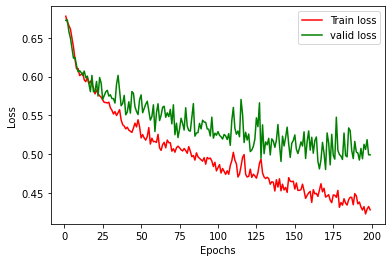

In [27]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'v'

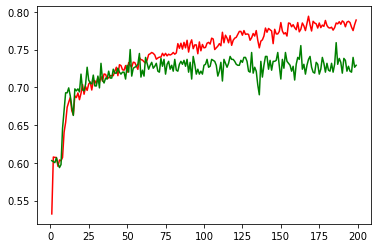

In [24]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
plt.v
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
### loss
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")

In [130]:
### Accuracy
print(f"Training accuracy|   Mean: {torch.tensor(traine_accuracy).mean()}   std: {torch.tensor(traine_accuracy).std()}")
print(f"validation accuracy| Mean: {torch.tensor(vale_accuracy).mean()}  std: {torch.tensor(vale_accuracy).std()}")

Training accuracy|   Mean: 0.7091323390151515   std: 0.052472118473039724
validation accuracy| Mean: 0.6945825441919192  std: 0.04727569250179902
